In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as sms

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, \
mean_squared_log_error
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Porter Delivery Time Estimation

### Problem Statement

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has several delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers based on what they are ordering, from where, and also the delivery partners.

This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

### Data Dictionary
Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below:

* market id: integer id for the market where the restaurant lies

* created at: the timestamp at which the order was placed

* actual delivery time: the timestamp when the order was delivered

* store_primary_category: category for the restaurant

* order protocol: integer code value for order protocol(how the order was placed le: through porter app, call to restaurant, pre booked, third party, porter website and others)

* total items: no of items in the order

* subtotal: final price of the order(in rupees)

* num_distinct items: the number of distinct items in the order

* min_item_price: price of the cheapest item in the order

* max_item_price: price of the costliest item in order

* total_onshift_partners: number of delivery partners on duty at the time order was placed

* total_busy_partners: number of delivery partners attending to other tasks

* total_outstanding_orders: total number of orders to be fulfilled at the moment

* estimated_store_to_consumer_driving_duration: approximate travel time from restaurant to customer

## Icon Legends
<table>
  <tr>
    <th width="25%"> <img src="infer.png" style="width:25%;"></th>
    <th width="25%"> <img src="todo.png" style="width:25%;"></th>
  </tr>
  <tr>
    <td><div align="center" style="font-size:120%">
        <font color="#21618C"><b>Inferences from outcome</b></font></div>
    </td>
    <td><div align="center" style="font-size:120%">
        <font color="#21618C"><b>Lets do it</b></font></div>
    </td>
</tr>
</table>


## Table of Content

1. **[Data Understanding](#understanding)**
2. **[Data Cleaning](#cleaning)**
3. **[Extracting Target Variable](#target)**
4. **[Missing Values](#missing)**
5. **[Outlier Treatment](#outlier)**
6. **[Feature Engineering](#feature)**
7. **[Univariate Analysis](#univariate)**
8. **[Bivariate Analysis](#bivariate)**
9. **[Statistical Analysis](#statistic)**
10. **[Encoding The Categorical Variables](#encoding)**
11. **[Scaling/Transformation](#scaling)**
12. **[Train Test Split](#split)**
13. **[Model Building](#model)**

<a id='understanding'> </a>
## 1. Data Understanding

In [2]:
data= pd.read_csv('porter_dataset.csv')
data.head(5)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,thai,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,fast,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,fast,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0


**Dimensions of the data**

In [3]:
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])

Rows: 175777
Columns: 14


**Info about the data:**

Consists of the total number of entries in tha data, non-null entries and datatype for each variable.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_primary_category                        175777 non-null  object 
 4   order_protocol                                175777 non-null  float64
 5   total_items                                   175777 non-null  int64  
 6   subtotal                                      175777 non-null  int64  
 7   num_distinct_items                            175777 non-null  int64  
 8   min_item_price                                175777 non-null  int64  
 9   max_item_price                                17

**5 point summmary of numerical columns**

In [5]:
data.drop(columns= ['market_id','order_protocol','store_primary_category']).describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000
mean,3.204976,2697.111147,2.675060,684.965433,1160.158616,44.918664,41.861381,58.230115,546.077240
std,2.674055,1828.554893,1.625681,519.882924,560.828571,34.544724,32.168505,52.731043,218.717798
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000
25%,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,384.000000
50%,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,544.000000
75%,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,703.000000
max,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2088.000000


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> There are few errors in the dataset:<br><br>
                        1. Subtotal has min value as 0 which is not possible since order will be of some amount and it can't be zero.<br>
                        2. Min_item_price, and max_item_price also cannot be zero or less than zero because the price of an order will always be greater than zero until it's free which practically is not the case.<br> 
                        3. Onshift partners and busy partners also cannot be negative as the count cannot be negative. Same goes with outstanding orders which also contain negative values. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>


**Summary for categorical variables**

In [6]:
data[['market_id', 'order_protocol','store_primary_category']].astype('object').describe()

,market_id,order_protocol,store_primary_category
count,175777.0,175777.0,175777
unique,6.0,7.0,73
top,2.0,1.0,american
freq,53469.0,48404.0,18183


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. Market_id 2 received the maximum orders which are 53469 as compared to other markets.<br>
2. There are 73 unique category of stores out of which american is the most popular one.<br>
3. Most people ordered through porter with count of 48404.0 which account for almost 30% of the total orders.<br>
4. The average bill amount for all the orders is Rs 2224.<br>
5. On an average the minimum price of an item in each order was 595 and the maximum was 1095.<br>
6. On each order, outstanding orders are more as compared to the number of partners that are available to deliver them.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>


<a id='cleaning'> </a>
## 2. Data Cleaning

<table align="left">
    <tr>
        <td width="8%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Let's clean the data by correcting the errors found in data understanding.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

###### Let's check the values where subtotal is null

In [7]:
data[data['subtotal']==0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
988,4.0,2015-01-25 17:28:32,2015-01-25 18:05:32,american,3.0,7,0,7,295,1225,6.0,22.0,8.0,241.0
1694,2.0,2015-02-07 17:25:00,2015-02-07 18:00:00,indian,4.0,5,0,2,169,200,19.0,13.0,13.0,512.0
3652,1.0,2015-01-31 01:42:46,2015-01-31 02:19:46,japanese,3.0,2,0,2,405,1395,16.0,16.0,16.0,200.0
3909,1.0,2015-02-12 19:15:20,2015-02-12 19:58:20,breakfast,3.0,1,0,1,1495,1495,16.0,16.0,20.0,556.0
6617,4.0,2015-01-25 02:09:31,2015-01-25 02:53:31,greek,2.0,2,0,2,1799,2599,61.0,80.0,103.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169877,1.0,2015-01-28 02:21:37,2015-01-28 03:00:37,thai,3.0,5,0,5,350,1195,51.0,53.0,62.0,478.0
171181,4.0,2015-02-08 04:23:01,2015-02-08 05:13:01,vegan,1.0,2,0,2,625,963,5.0,6.0,16.0,513.0
171590,1.0,2015-01-26 03:54:50,2015-01-26 04:30:50,burger,3.0,5,0,3,800,1800,38.0,39.0,39.0,365.0
171976,5.0,2015-02-14 02:34:45,2015-02-14 03:24:45,latin-american,1.0,1,0,1,1200,1200,26.0,24.0,41.0,568.0


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> It is not possible for an order being placed even with one item to have the bill amount as 0. SO, we will drop these rows.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [8]:
data.drop(index= data[data['subtotal']==0].index, axis=0, inplace= True)

In [9]:
data.shape

(175616, 14)

In [10]:
data.subtotal.describe()

count    175616.000000
mean       2699.583785
std        1827.567568
min          95.000000
25%        1418.000000
50%        2225.000000
75%        3412.250000
max       26800.000000
Name: subtotal, dtype: float64

###### Let's check min item price as it also cannot be less than zero or even 0

In [11]:
data[data.min_item_price<=0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
646,2.0,2015-01-28 01:20:44,2015-01-28 02:00:44,thai,3.0,2,1368,2,0,1200,30.0,29.0,32.0,583.0
711,1.0,2015-01-29 02:59:28,2015-01-29 03:53:28,indian,4.0,3,1003,3,-86,1066,24.0,29.0,38.0,721.0
719,1.0,2015-02-16 01:16:49,2015-02-16 02:16:49,indian,4.0,24,3190,8,0,699,17.0,17.0,24.0,585.0
722,1.0,2015-02-03 03:36:16,2015-02-03 04:31:16,indian,4.0,7,1223,5,0,649,22.0,22.0,48.0,384.0
724,1.0,2015-01-25 21:38:45,2015-01-25 22:24:45,indian,4.0,6,958,6,0,599,17.0,9.0,9.0,765.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175020,1.0,2015-01-28 19:33:39,2015-01-28 20:11:39,indian,4.0,13,487,4,0,209,7.0,6.0,5.0,257.0
175200,4.0,2015-01-21 19:57:24,2015-01-21 20:30:24,pizza,3.0,2,1395,2,0,695,44.0,41.0,56.0,199.0
175561,1.0,2015-02-15 22:15:36,2015-02-15 22:50:36,indian,4.0,9,946,5,0,299,24.0,17.0,17.0,383.0
175562,1.0,2015-02-09 05:16:26,2015-02-09 06:02:26,indian,4.0,6,348,3,0,169,20.0,20.0,18.0,624.0


In [12]:
data.drop(index= data[data.min_item_price<=0].index, axis=0, inplace=True)

In [13]:
data.min_item_price.describe()

count    173430.000000
mean        693.522609
std         517.399125
min           1.000000
25%         300.000000
50%         599.000000
75%         949.000000
max       14700.000000
Name: min_item_price, dtype: float64

######  Same goes with max item price as well

In [14]:
data[data.max_item_price<=0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration


In [15]:
data.max_item_price.describe()

count    173430.000000
mean       1163.111959
std         556.982369
min          60.000000
25%         800.000000
50%        1095.000000
75%        1395.000000
max       14700.000000
Name: max_item_price, dtype: float64

###### Let's Treat Onshift partners because it also has negative values which is not possible

In [16]:
data[data.total_onshift_dashers<0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
5535,3.0,2015-02-14 01:48:58,2015-02-14 02:39:58,american,1.0,2,3538,2,1238,1606,-2.0,2.0,10.0,266.0
11396,3.0,2015-01-21 21:02:32,2015-01-21 21:48:32,smoothie,2.0,1,986,1,892,827,-2.0,5.0,1.0,787.0
23697,3.0,2015-02-08 18:28:15,2015-02-08 19:10:15,indian,3.0,2,1327,1,680,615,-1.0,6.0,6.0,368.0
27924,3.0,2015-02-07 19:55:46,2015-02-07 20:44:46,hawaiian,1.0,1,1202,1,987,1092,-1.0,9.0,5.0,773.0
29825,1.0,2015-02-02 22:27:36,2015-02-02 23:23:36,american,1.0,2,2831,2,681,635,-1.0,13.0,16.0,394.0
47616,1.0,2015-01-25 02:55:01,2015-01-25 03:48:01,chinese,1.0,2,1803,2,818,1061,-1.0,4.0,7.0,381.0
53207,1.0,2015-01-29 02:07:49,2015-01-29 03:01:49,salad,5.0,2,1117,2,339,956,-3.0,0.0,16.0,187.0
54001,1.0,2015-02-01 03:42:22,2015-02-01 04:39:22,cafe,5.0,7,2666,7,379,437,-2.0,8.0,5.0,486.0
105659,1.0,2015-02-09 03:35:22,2015-02-09 04:39:22,japanese,3.0,2,1862,2,488,1162,-2.0,3.0,3.0,603.0
106422,3.0,2015-02-14 04:21:45,2015-02-14 05:24:45,barbecue,4.0,4,1874,3,110,1378,-2.0,-1.0,11.0,971.0


In [17]:
data.drop(index= data[data.total_onshift_dashers<0].index, inplace= True)

###### Treating total_busy_partners

In [18]:
data[data.total_busy_dashers<0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
7133,1.0,2015-02-08 15:41:45,2015-02-08 16:34:45,sandwich,3.0,1,1514,1,1116,1063,1.0,-1.0,3.0,650.0
20272,1.0,2015-02-10 19:35:28,2015-02-10 20:33:28,japanese,1.0,2,1578,2,441,803,0.0,-1.0,9.0,735.0
22110,1.0,2015-01-29 05:09:24,2015-01-29 05:57:24,smoothie,3.0,1,1237,1,984,978,5.0,-1.0,7.0,466.0
23920,1.0,2015-02-13 03:18:12,2015-02-13 04:15:12,burger,1.0,6,5773,6,554,1926,10.0,-1.0,6.0,552.0
29932,1.0,2015-02-12 00:38:22,2015-02-12 01:34:22,dim-sum,1.0,2,6083,2,2907,3199,9.0,-1.0,5.0,427.0
42676,3.0,2015-02-07 05:44:49,2015-02-07 06:35:49,thai,3.0,2,1859,2,295,1240,6.0,-1.0,8.0,732.0
45178,1.0,2015-01-21 18:46:51,2015-01-21 19:35:51,american,1.0,1,4314,1,4147,4077,9.0,-2.0,-5.0,738.0
50763,3.0,2015-02-13 23:26:37,2015-02-14 00:04:37,mexican,1.0,2,1540,2,424,1236,6.0,-1.0,3.0,380.0
52371,1.0,2015-01-30 19:55:28,2015-01-30 20:47:28,cafe,5.0,5,1900,5,331,305,5.0,-3.0,3.0,612.0
52730,1.0,2015-02-17 01:04:53,2015-02-17 01:55:53,sandwich,1.0,1,1661,1,1136,1211,2.0,-4.0,12.0,153.0


In [19]:
data.drop(index= data[data.total_busy_dashers<0].index, inplace= True)

###### Treating total_outstanding_orders

In [20]:
data[data.total_outstanding_orders<0]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
4599,1.0,2015-02-18 00:36:21,2015-02-18 01:15:21,catering,2.0,2,1940,1,840,856,11.0,14.0,-2.0,460.0
17275,3.0,2015-02-03 03:04:22,2015-02-03 03:46:22,indian,4.0,3,1778,2,158,869,7.0,10.0,-2.0,743.0
18219,1.0,2015-01-25 21:15:30,2015-01-25 21:52:30,asian,1.0,3,2039,3,393,798,9.0,7.0,-1.0,393.0
20592,1.0,2015-02-08 19:49:17,2015-02-08 20:33:17,korean,1.0,2,1641,2,754,1217,5.0,2.0,-1.0,537.0
32639,1.0,2015-01-31 17:32:31,2015-01-31 18:06:31,indian,4.0,3,617,2,258,365,6.0,6.0,-6.0,217.0
39567,1.0,2015-01-27 01:50:34,2015-01-27 02:22:34,other,1.0,3,2258,2,126,837,24.0,8.0,-2.0,317.0
41694,1.0,2015-02-17 02:55:02,2015-02-17 03:37:02,american,4.0,1,1317,1,1058,1042,6.0,7.0,-3.0,528.0
50087,3.0,2015-01-23 00:25:58,2015-01-23 01:15:58,pizza,1.0,3,1963,2,562,855,2.0,5.0,-6.0,801.0
60338,1.0,2015-02-18 01:50:48,2015-02-18 02:49:48,chinese,5.0,4,3146,4,468,945,2.0,5.0,-3.0,964.0
63665,1.0,2015-02-14 06:10:15,2015-02-14 06:59:15,dessert,5.0,2,2117,2,1076,1051,13.0,9.0,-1.0,940.0


In [21]:
data.drop(index= data[data.total_outstanding_orders<0].index, inplace=True)

**Let's check if there are entries where min item price is greater than max item price, which is technically not possible.**

In [22]:
data[data.min_item_price>data.max_item_price]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
240,4.0,2015-01-24 03:03:18,2015-01-24 03:57:18,mexican,1.0,1,1403,1,1314,1292,129.0,127.0,205.0,464.0
1413,4.0,2015-02-03 18:25:33,2015-02-03 19:10:33,breakfast,2.0,12,4574,4,459,420,21.0,19.0,23.0,575.0
1490,2.0,2015-02-13 20:49:22,2015-02-13 21:22:22,pizza,3.0,1,1996,1,1584,1496,46.0,52.0,59.0,175.0
1923,5.0,2015-01-29 03:18:34,2015-01-29 04:00:34,mexican,1.0,1,1529,1,1200,1093,23.0,22.0,32.0,298.0
2513,3.0,2015-02-01 01:35:06,2015-02-01 02:13:06,greek,3.0,2,2236,2,1088,1080,39.0,34.0,37.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175233,4.0,2015-02-07 20:52:15,2015-02-07 21:31:15,pizza,3.0,1,3174,1,1513,1403,38.0,31.0,32.0,680.0
175404,4.0,2015-02-16 02:34:06,2015-02-16 03:31:06,vietnamese,5.0,2,2086,1,904,878,85.0,77.0,152.0,409.0
175514,4.0,2015-02-03 02:57:44,2015-02-03 03:48:44,vietnamese,5.0,2,2082,2,1020,928,88.0,87.0,150.0,390.0
175736,1.0,2015-01-30 19:24:55,2015-01-30 20:05:55,indian,4.0,1,1142,1,737,701,22.0,19.0,32.0,347.0


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> There are 689 entries where this error has been made and since there is no way we can ascertain if they are either interchanged or some other problem occured, we have to drop these.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [23]:
data.drop(index= data[data.min_item_price>data.max_item_price].index, inplace=True)

In [24]:
data.shape

(172663, 14)

<a id='target'> </a>
## 3. Extracting Target Variable

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Converting `created_at` and `actual_delivery_time` column to datetime and extracting target.</b>
                </font>
            </div>
        </td>
    </tr>
</table>


In [25]:
data['created_at']= pd.to_datetime(data['created_at'])

In [26]:
data['actual_delivery_time']= pd.to_datetime(data['actual_delivery_time'])

In [27]:
data['delivery_time_in_mins']= (data['actual_delivery_time']-data['created_at']).dt.total_seconds()/60

In [28]:
# delivery time in minutes
data['delivery_time_in_mins'].describe()

count    172663.000000
mean         46.228474
std           9.331164
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: delivery_time_in_mins, dtype: float64

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> We have created our target variable that explains delivery time in minutes<br><br>
1. The lowest delivery time is 32 minutes.<br>
2. The highest time taken to deliver an order is 110 minutes, and <br>
3. The average delivery time is 45 minutes.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='missing'> </a>
## 4. Missing Values 

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Count of missing Values in each variable </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [29]:
data.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
delivery_time_in_mins                           0
dtype: int64

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> There are no missing values present in the dataset.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='outlier'> </a>
## 5. Outlier Treatment

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Let's Visualize the presence of outliers in each numerical variable</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [30]:
data.select_dtypes(include= np.number).columns

Index(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'delivery_time_in_mins'],
      dtype='object')

In [31]:
num_cols= ['total_items', 'subtotal', 'num_distinct_items','min_item_price','max_item_price','total_onshift_dashers',
           'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration','delivery_time_in_mins']

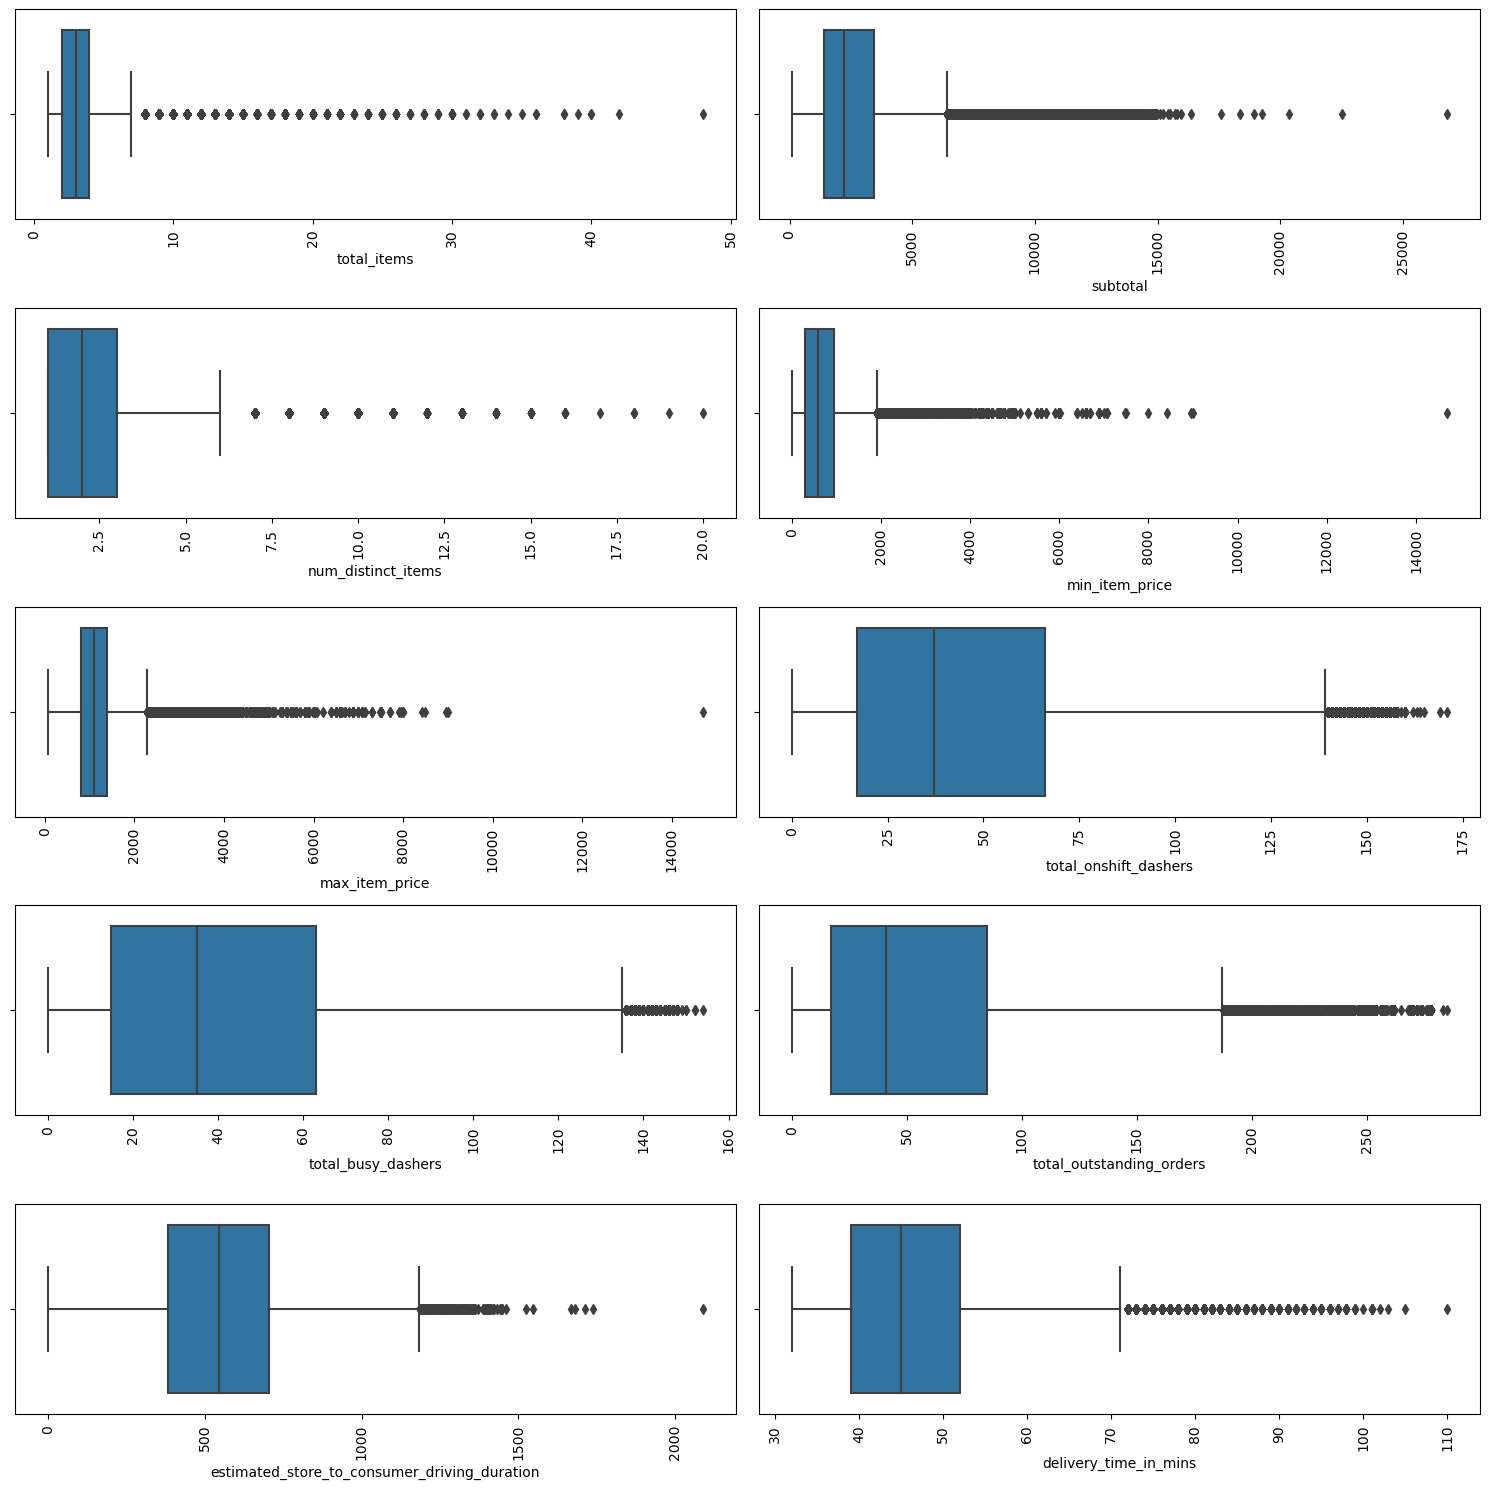

In [32]:
t=1
plt.figure(figsize= (15,15))
for i in num_cols:
    plt.subplot(5,2,t)
    sns.boxplot(data[i])
    plt.xticks(rotation= 90)
    t+=1
plt.tight_layout()
plt.show()

**Let's remove the outliers**

In [33]:
for i in num_cols:
    q1, q3= np.quantile(data[i], [0.25, 0.75])
    iqr= q3 - q1
    ll= q1 -1.5*iqr
    ul= q3 +1.5*iqr
    data= data.loc[~((data[i] < ll) | (data[i]> ul))]

**Checking if the outliers have been removed**

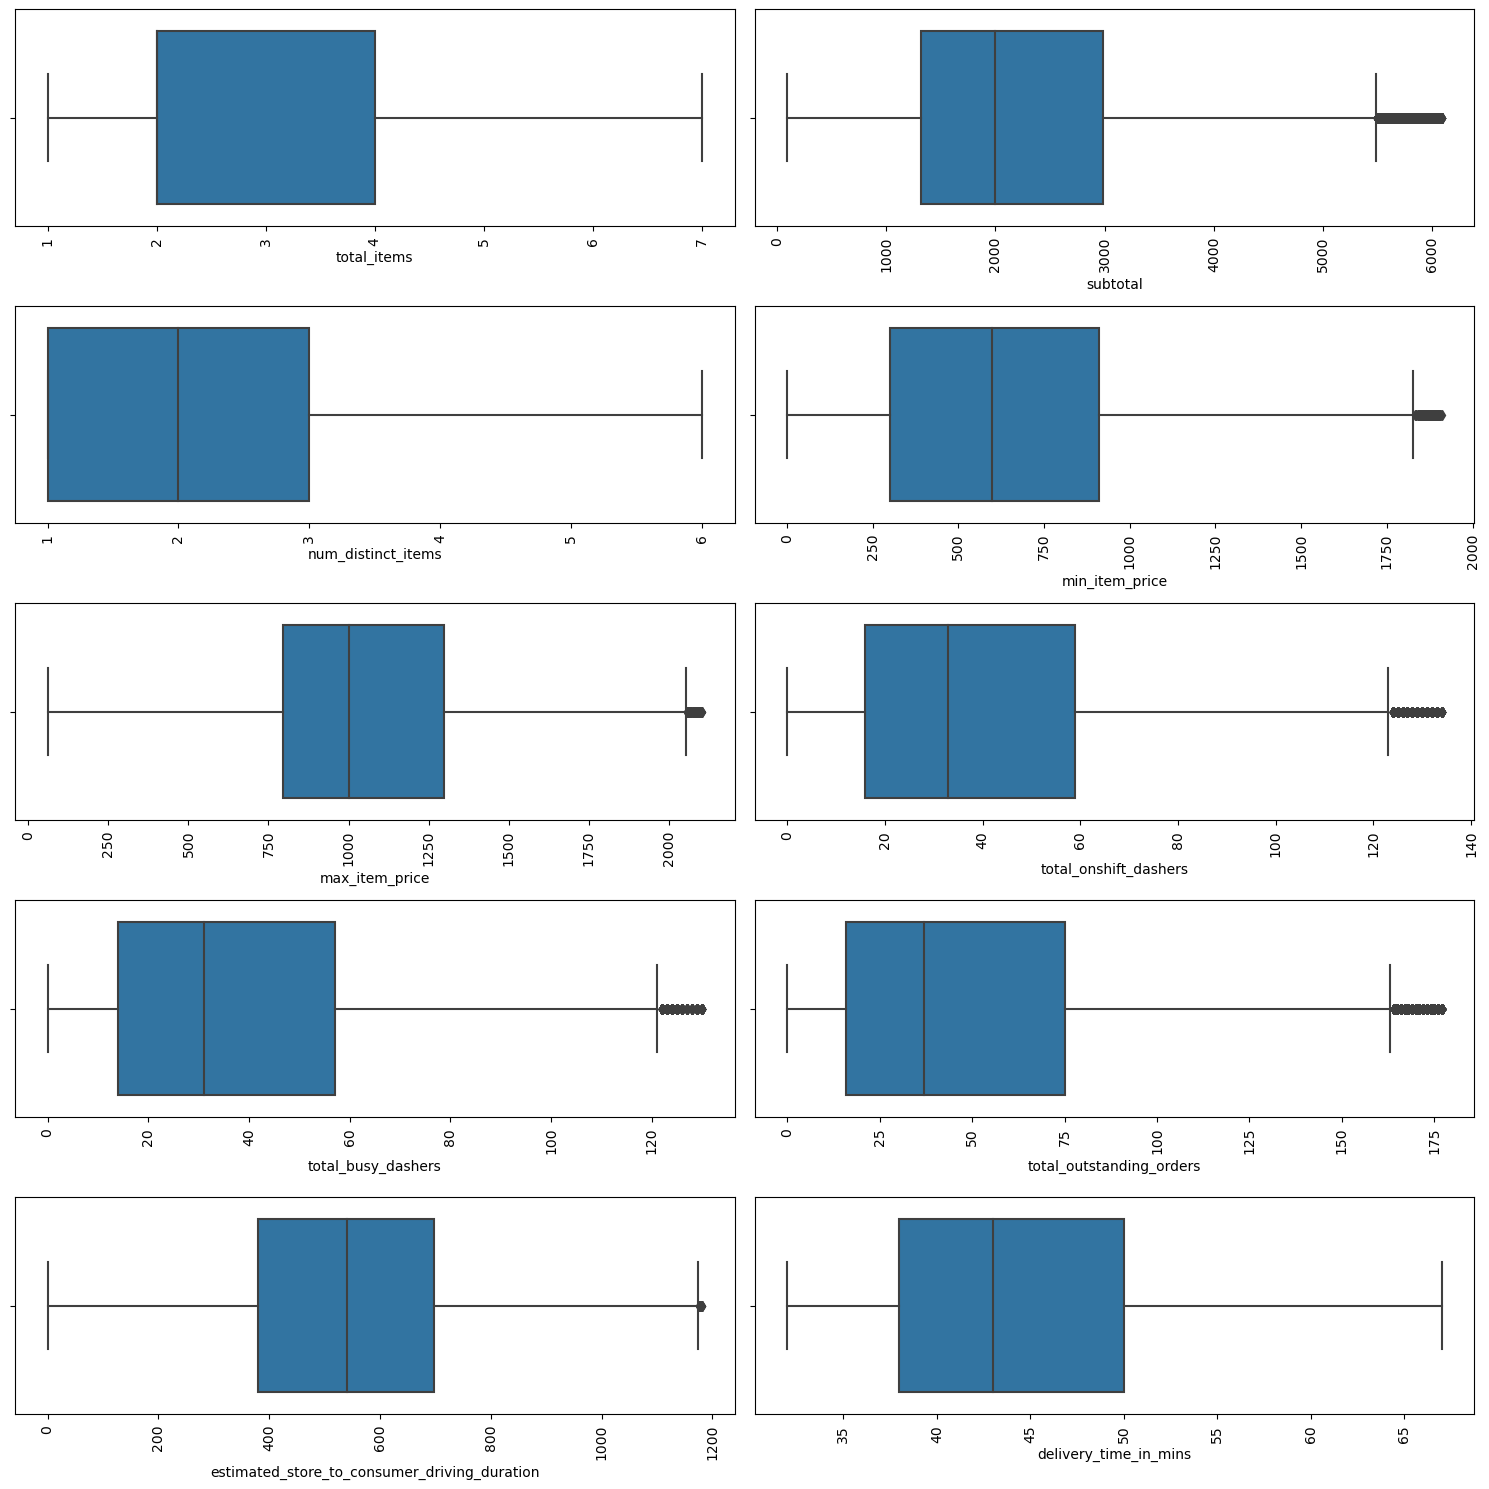

In [34]:
t=1
plt.figure(figsize= (15,15))
for i in num_cols:
    plt.subplot(5,2,t)
    sns.boxplot(data[i])
    plt.xticks(rotation= 90)
    t+=1
plt.tight_layout()
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> The outliers have been removed.</b>
                </font>
            </div>
        </td>
    </tr>
</table>


In [35]:
data.shape

(142930, 15)

In [36]:
data.reset_index(drop= True, inplace= True)

**Let's find the correlation between the variables**

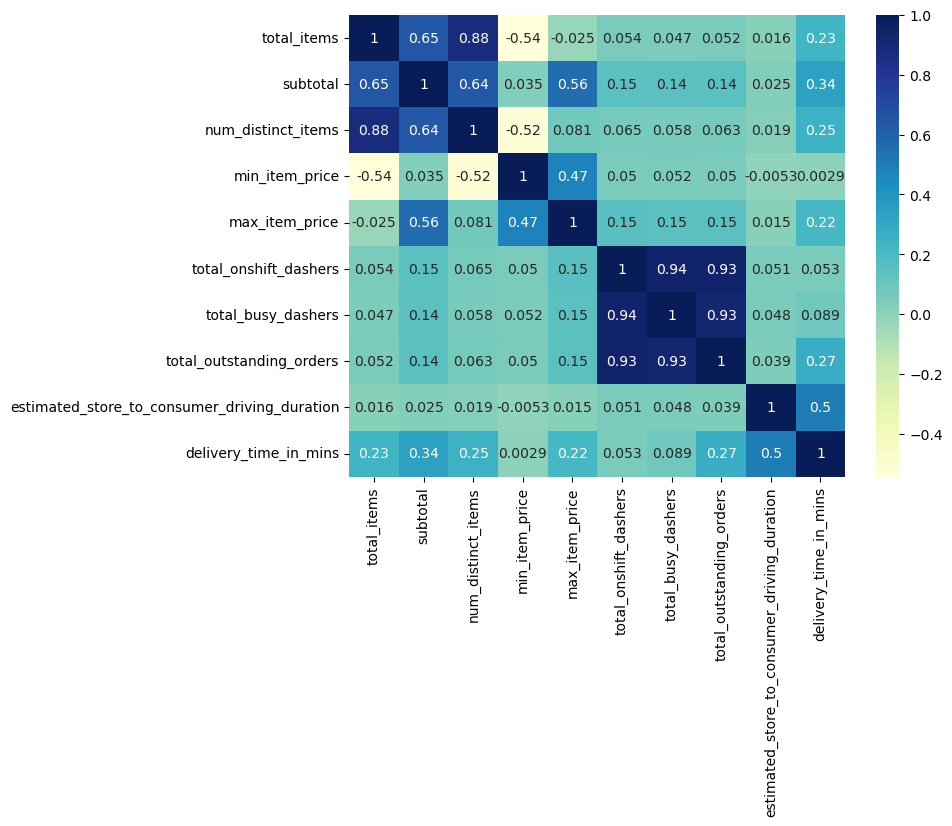

In [37]:
plt.figure(figsize= (8,6))
sns.heatmap(data[num_cols].corr(), annot= True, cmap='YlGnBu')
plt.show()

<a id='feature'> </a>
## 6. Feature Engineering

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Extracting various features from the data.</b>
                </font>
            </div>
        </td>
    </tr>
</table>


In [38]:
data['order_month']= data['created_at'].dt.month

In [39]:
data['order_hour']= data['created_at'].dt.hour

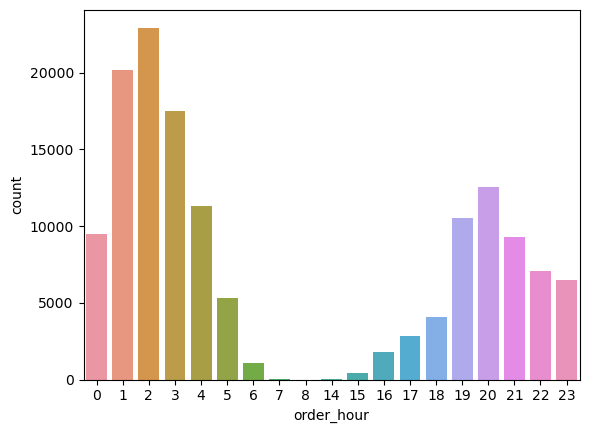

In [40]:
sns.countplot(data['order_hour'])
plt.show()

By looking at the above graph, we can see that the orders were created mostly from 12 to 5 in the morning and from 6 to 12 in the night, based on this we can derive a new column which explains the time of the day in which orders were created the most.

In [41]:
def order_time(i):
    if i in range(0,7):
        return 'Late Night'
    elif i in range(6,13):
        return 'Morning'
    elif i in range(12,19):
        return 'Afternoon'
    else:
        return 'Night'  

In [42]:
data['time_of_day']= data['order_hour'].apply(order_time)

In [43]:
del data['order_hour']

In [44]:
data['order_weekday']= data['created_at'].dt.weekday

In [45]:
data['total_available_dashers']= (data['total_onshift_dashers'] - data['total_busy_dashers'])

In [46]:
data['Price_Range']= data['max_item_price']-data['min_item_price']

In [47]:
data['Price_Range'].describe()

count    142930.000000
mean        400.236458
std         400.913002
min           0.000000
25%           0.000000
50%         300.000000
75%         679.000000
max        2044.000000
Name: Price_Range, dtype: float64

Let's drop the min item price and max item price based on which we have created price range, and total items as num distinct items have better correlation with the target. Also total and distinct have high correlation among each other which might create a problem of multicollinearity. Droping the unrelevant columns too which are created at and actual delivery time.

In [48]:
data.drop(columns=['min_item_price','max_item_price','total_items','created_at','actual_delivery_time'], axis=1, inplace=True)

**Let's find and create the number of pending orders per market**

In [49]:
data.groupby('market_id')['total_outstanding_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
market_id,,,,,,,,
1.0,30650.0,28.810767,26.291195,0.0,9.0,21.0,41.0,177.0
2.0,41903.0,68.853567,41.624723,0.0,36.0,62.0,94.0,177.0
3.0,18292.0,18.890772,19.263186,0.0,5.0,13.0,27.0,177.0
4.0,36347.0,72.956970,47.632288,0.0,32.0,65.0,112.0,177.0
5.0,15219.0,25.478218,21.086542,0.0,11.0,20.0,33.0,177.0
6.0,519.0,48.728324,41.286191,0.0,16.0,37.0,72.0,176.0


In [50]:
data['market_wise_pending_orders']= data.groupby('market_id')['total_outstanding_orders'].transform('median')

**Creating Total available dashers per market**

In [51]:
data.groupby('market_id')['total_available_dashers'].describe()

,count,mean,std,min,25%,50%,75%,max
market_id,,,,,,,,
1.0,30650.0,0.757553,3.761024,-59.0,-1.0,0.0,1.0,50.0
2.0,41903.0,3.513663,12.419547,-60.0,-1.0,2.0,8.0,75.0
3.0,18292.0,1.626995,4.310511,-55.0,0.0,0.0,3.0,67.0
4.0,36347.0,3.067351,14.551082,-63.0,0.0,3.0,9.0,67.0
5.0,15219.0,3.868782,6.791029,-56.0,0.0,3.0,7.0,60.0
6.0,519.0,2.487476,9.323411,-49.0,0.0,1.0,5.0,43.0


In [52]:
data['dashers_available_per_market']= data.groupby('market_id')['total_available_dashers'].transform('median')

**Order Amount per market**

In [53]:
 data.groupby('market_id')['subtotal'].describe()

,count,mean,std,min,25%,50%,75%,max
market_id,,,,,,,,
1.0,30650.0,2284.801370,1204.520810,109.0,1328.25,2027.0,3000.0,6084.0
2.0,41903.0,2233.098060,1172.059394,145.0,1300.00,1990.0,2900.0,6085.0
3.0,18292.0,2219.589001,1202.358625,95.0,1274.00,1966.0,2935.0,6085.0
4.0,36347.0,2374.973725,1234.917168,125.0,1400.00,2100.0,3145.0,6085.0
5.0,15219.0,2135.586372,1164.180732,175.0,1220.00,1890.0,2795.0,6085.0
6.0,519.0,2261.005780,1152.410337,328.0,1393.00,2020.0,2945.0,5800.0


In [54]:
data['order_amount_per_market']= data.groupby('market_id')['subtotal'].transform('median')

In [56]:
data.head()

,market_id,store_primary_category,order_protocol,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time_in_mins,order_month,time_of_day,order_weekday,total_available_dashers,Price_Range,market_wise_pending_orders,dashers_available_per_market,order_amount_per_market
0,1.0,american,1.0,3441,4,33.0,14.0,21.0,861.0,47.0,2,Night,4,19.0,682,21.0,0.0,2027.0
1,2.0,mexican,2.0,1900,1,1.0,2.0,2.0,690.0,44.0,2,Night,1,-1.0,0,62.0,2.0,1990.0
2,2.0,thai,3.0,4771,3,8.0,6.0,18.0,289.0,55.0,2,Late Night,0,2.0,784,62.0,2.0,1990.0
3,1.0,fast,1.0,1525,1,5.0,6.0,8.0,795.0,59.0,2,Late Night,3,-1.0,0,21.0,0.0,2027.0
4,1.0,fast,1.0,4475,3,4.0,1.0,1.0,542.0,56.0,2,Late Night,4,3.0,900,21.0,0.0,2027.0


In [57]:
data.isnull().sum()

market_id                                       0
store_primary_category                          0
order_protocol                                  0
subtotal                                        0
num_distinct_items                              0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
delivery_time_in_mins                           0
order_month                                     0
time_of_day                                     0
order_weekday                                   0
total_available_dashers                         0
Price_Range                                     0
market_wise_pending_orders                      0
dashers_available_per_market                    0
order_amount_per_market                         0
dtype: int64

<a id='univariate'> </a>
## 7. Univariate Analysis

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Visualizing the variables and drawing inferences from the numerical and categorical columns.</b>
                </font>
            </div>
        </td>
    </tr>
</table>


In [58]:
data.select_dtypes(include= np.number).columns

Index(['market_id', 'order_protocol', 'subtotal', 'num_distinct_items',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_time_in_mins',
       'order_month', 'order_weekday', 'total_available_dashers',
       'Price_Range', 'market_wise_pending_orders',
       'dashers_available_per_market', 'order_amount_per_market'],
      dtype='object')

In [59]:
cat_cols= ['market_id', 'order_protocol', 'store_primary_category','num_distinct_items', 'order_weekday', 
           'order_month', 'time_of_day'] 
num_cols=[]
for i in data.columns:
    if i not in cat_cols:
        num_cols.append(i)
num_cols   

['subtotal',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_store_to_consumer_driving_duration',
 'delivery_time_in_mins',
 'total_available_dashers',
 'Price_Range',
 'market_wise_pending_orders',
 'dashers_available_per_market',
 'order_amount_per_market']

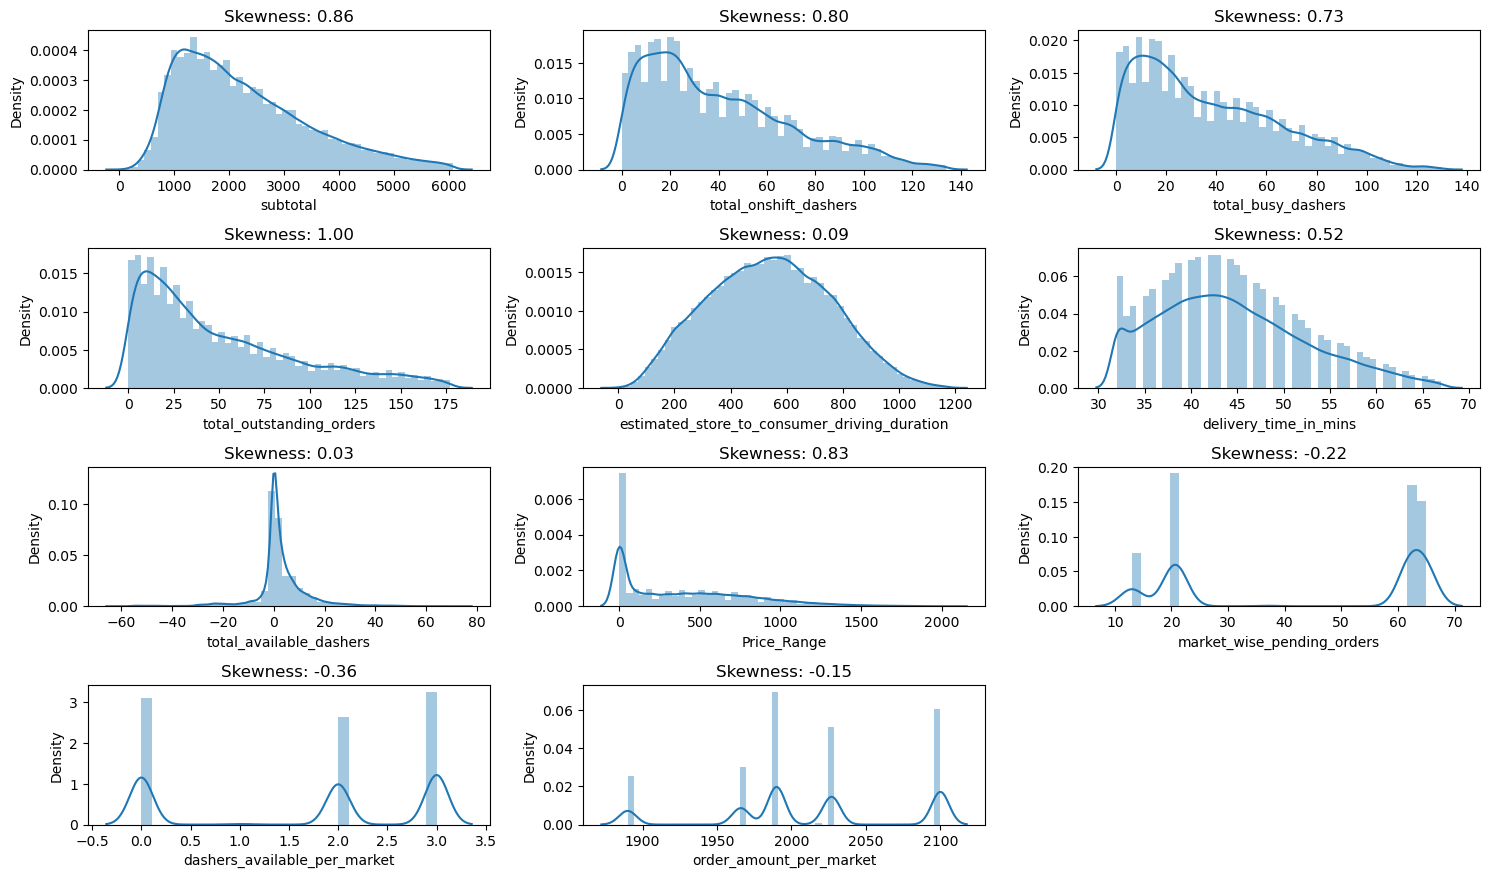

In [60]:
t=1
plt.figure(figsize= (15,15))
for i in num_cols:
    plt.subplot(7,3,t)
    sns.distplot(data[i])
    plt.title('Skewness: %.2f'%(data[i].skew()))
    t+=1
plt.tight_layout()
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Max_item price,estimated store to consumer driving duration, delivery time, total available dashers, market wise pending orders, dashers available per market, and order amount per market are normally distributed variables and rest all are little right skewed. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

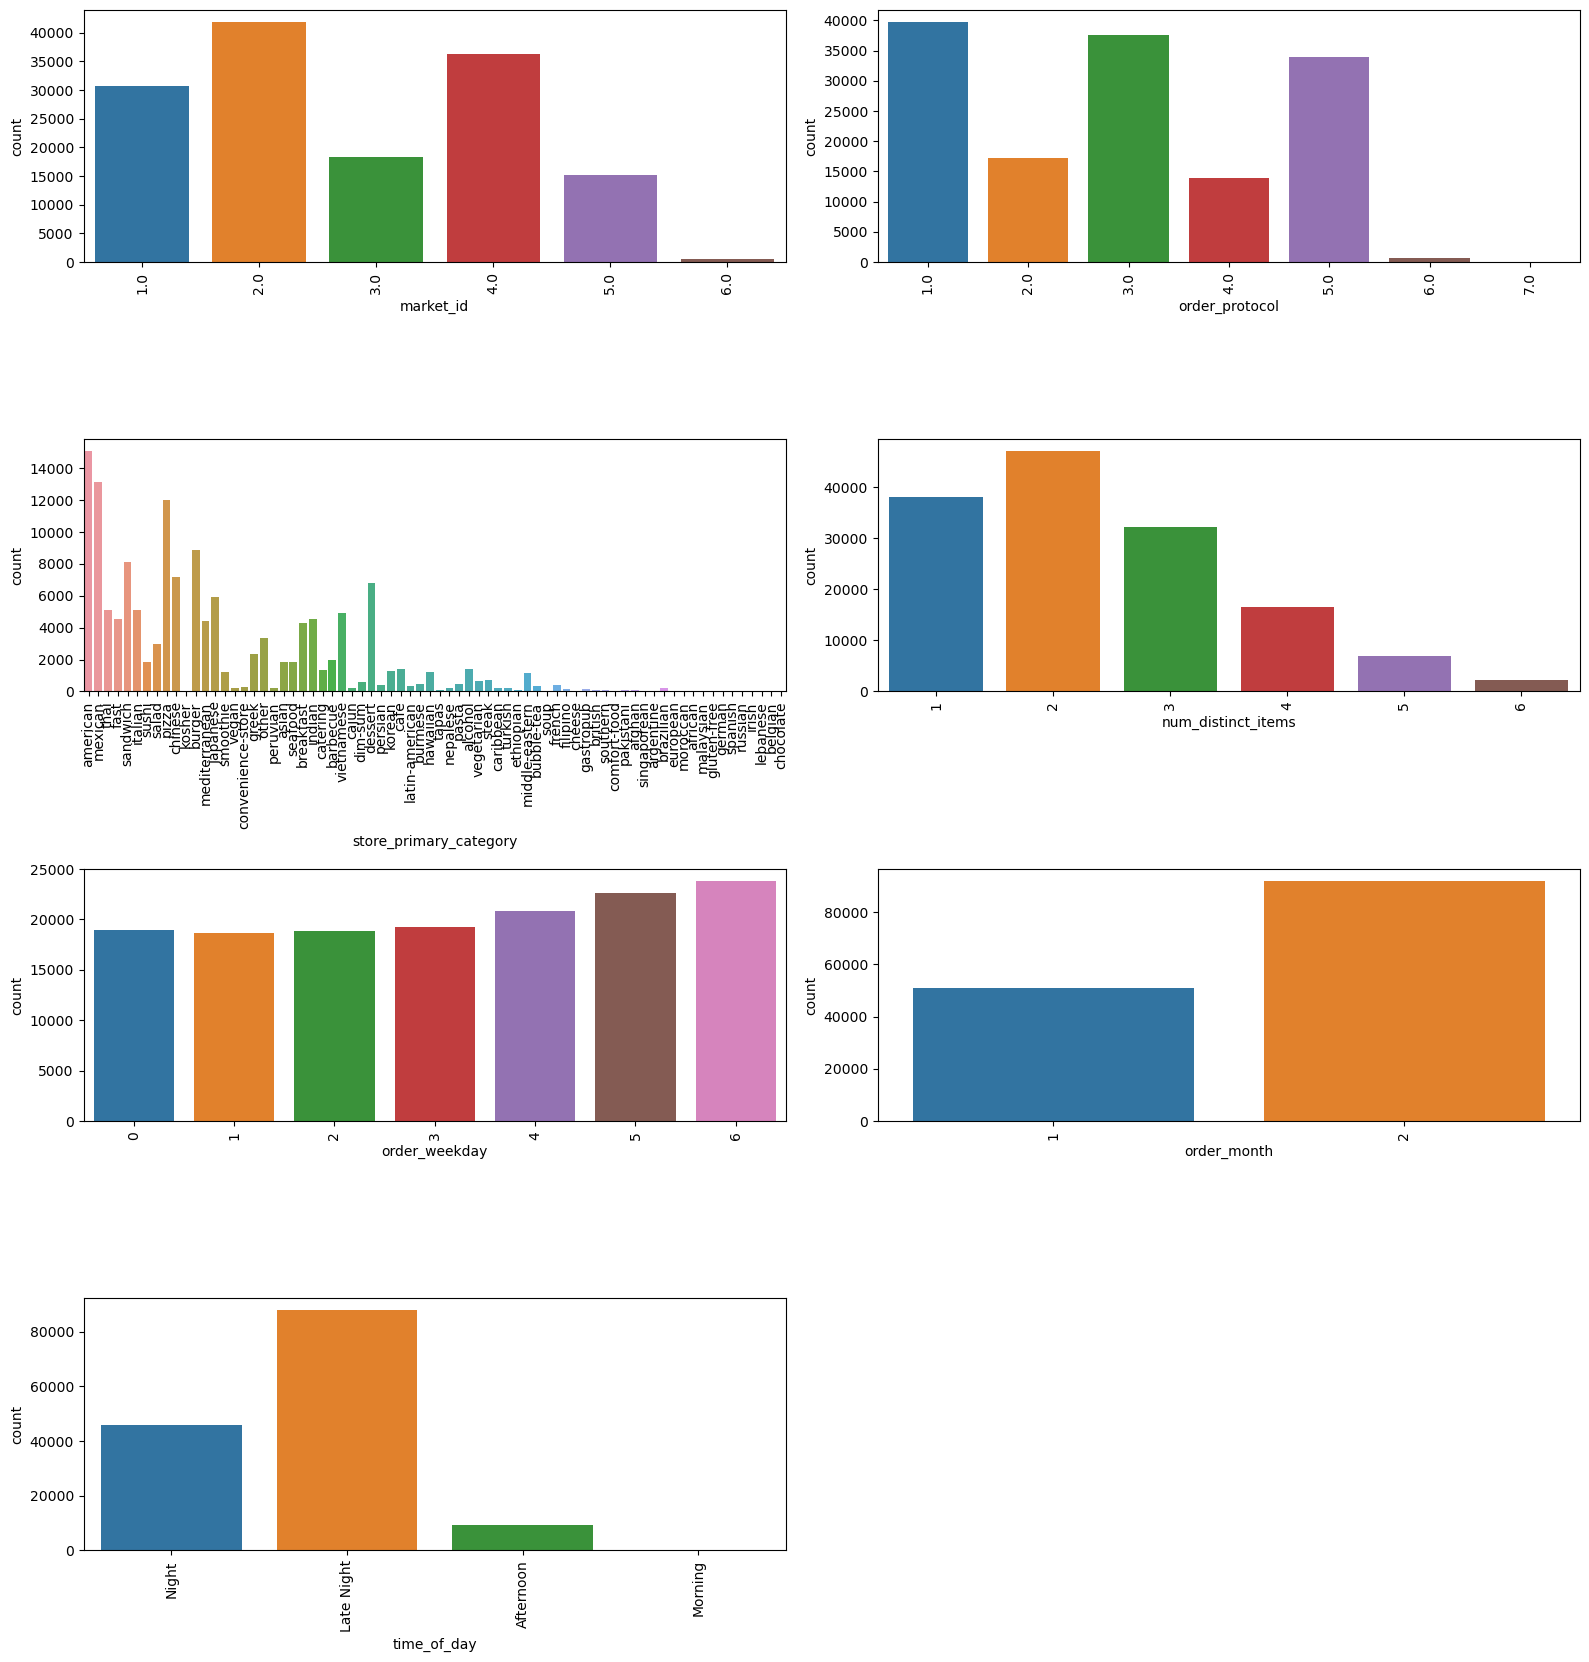

In [61]:
t=1
plt.figure(figsize= (16,20))
for i in cat_cols:
    plt.subplot(5,2,t)
    sns.countplot(data[i])
    plt.xticks(rotation= 90)
    t+=1
plt.tight_layout()
plt.show()

In [62]:
data['market_id'].value_counts(normalize= True)*100

2.0    29.317148
4.0    25.429931
1.0    21.444064
3.0    12.797873
5.0    10.647870
6.0     0.363115
Name: market_id, dtype: float64

In [63]:
data['order_protocol'].value_counts(normalize= True)*100

1.0    27.805219
3.0    26.319177
5.0    23.687819
2.0    12.029665
4.0     9.726440
6.0     0.420486
7.0     0.011194
Name: order_protocol, dtype: float64

In [64]:
data['store_primary_category'].value_counts(normalize= True).head(10)*100

american    10.527531
mexican      9.208004
pizza        8.410411
burger       6.193241
sandwich     5.692297
chinese      5.010145
dessert      4.756874
japanese     4.143287
italian      3.587071
thai         3.582873
Name: store_primary_category, dtype: float64

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. Most of the orders were from market id 2, 4 and 1 respectively which account for 76% of the total orders.<br>
2. Maximum orders were booked through porter app (1.0) or pre-booked(3.0) or through porter website(5.0) which account for almost 78% of the total orders.<br>
3. American, pizza  and mexican stores are the top 3 type of stores respectively from which customers ordered the most followed by burger, sandwich,chinese, dessert and japanese store categories.<br>
4. The amount of orders on the weekends were almost 5k to 7k more as compared to the orders on the weekdays.<br>
5. The dataset is of the starting months of 2015 in which the maximum orders were made in the second month.<br>
6. Restaurents received most orders from 12 to 6 in the night and from 6 to 12  in the evening. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='bivariate'> </a>
## 8. Bivariate Analysis

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Visualizing the variability of one variable with the other and drawing inferences from the numerical and categorical columns.</b>
                </font>
            </div>
        </td>
    </tr>
</table>


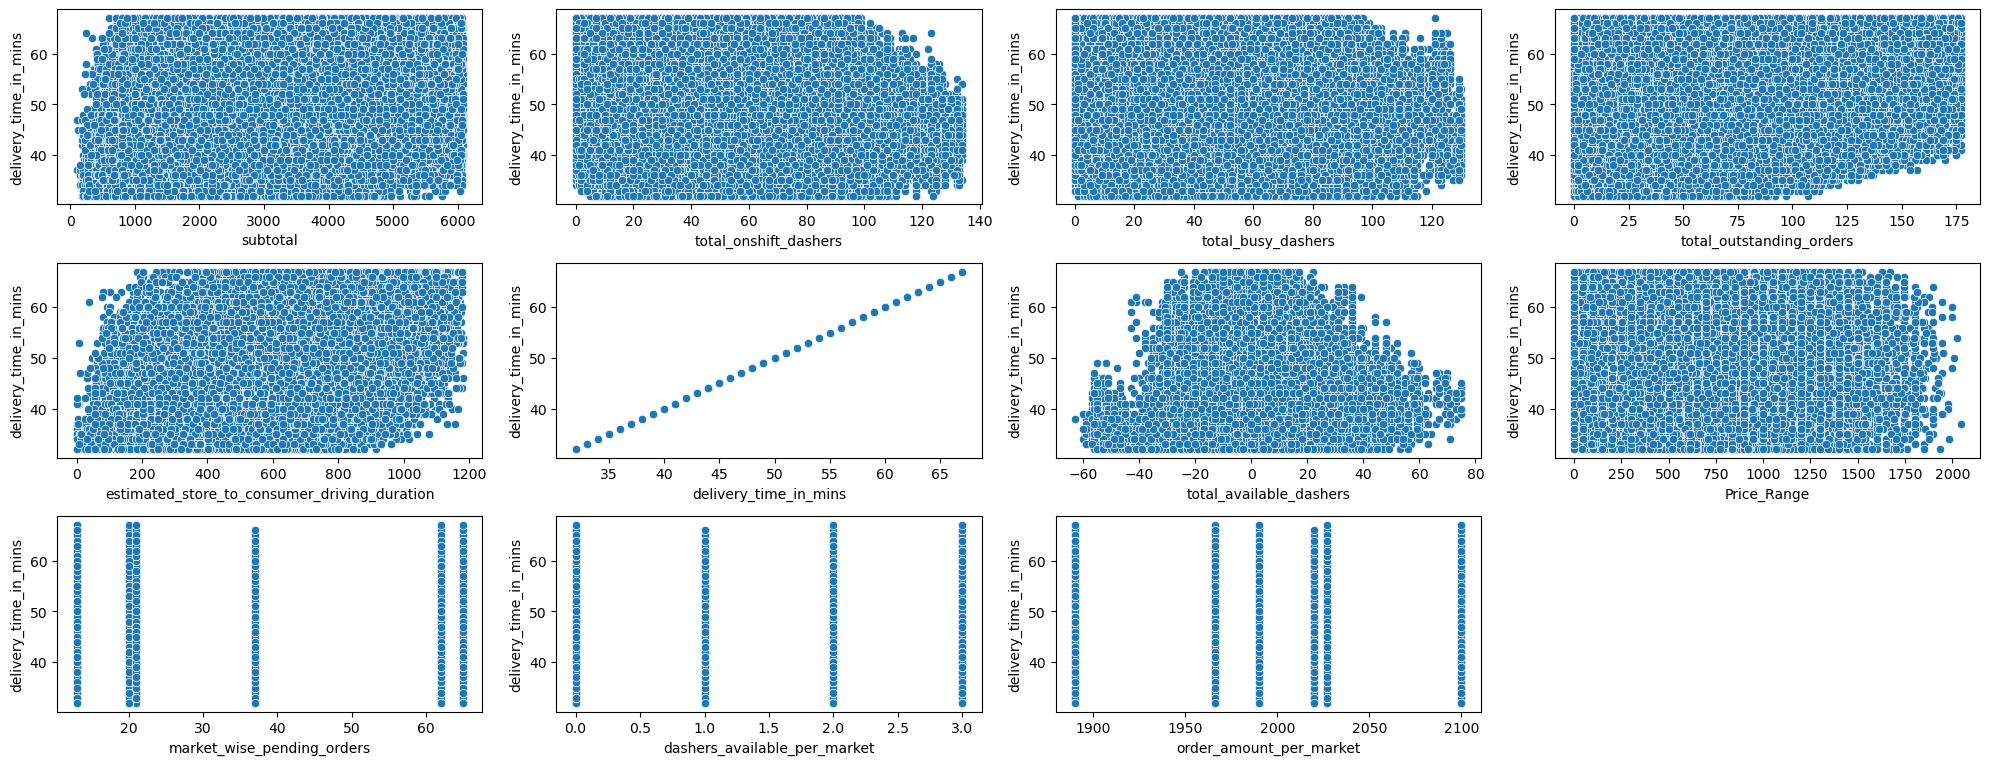

In [65]:
t=1
plt.figure(figsize= (20,20))
for i in num_cols:
    plt.subplot(8,4,t)
    sns.scatterplot(x= data[i], y= data['delivery_time_in_mins'])
    t+=1
plt.tight_layout()
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. If the price and estimated driving duration increases, delivery time also increases.<br>
                        2. As the total outstanding orders are increasing we can see an upward trend in delivery time as well. </b>
                </font>
            </div>
        </td>
    </tr>
</table>


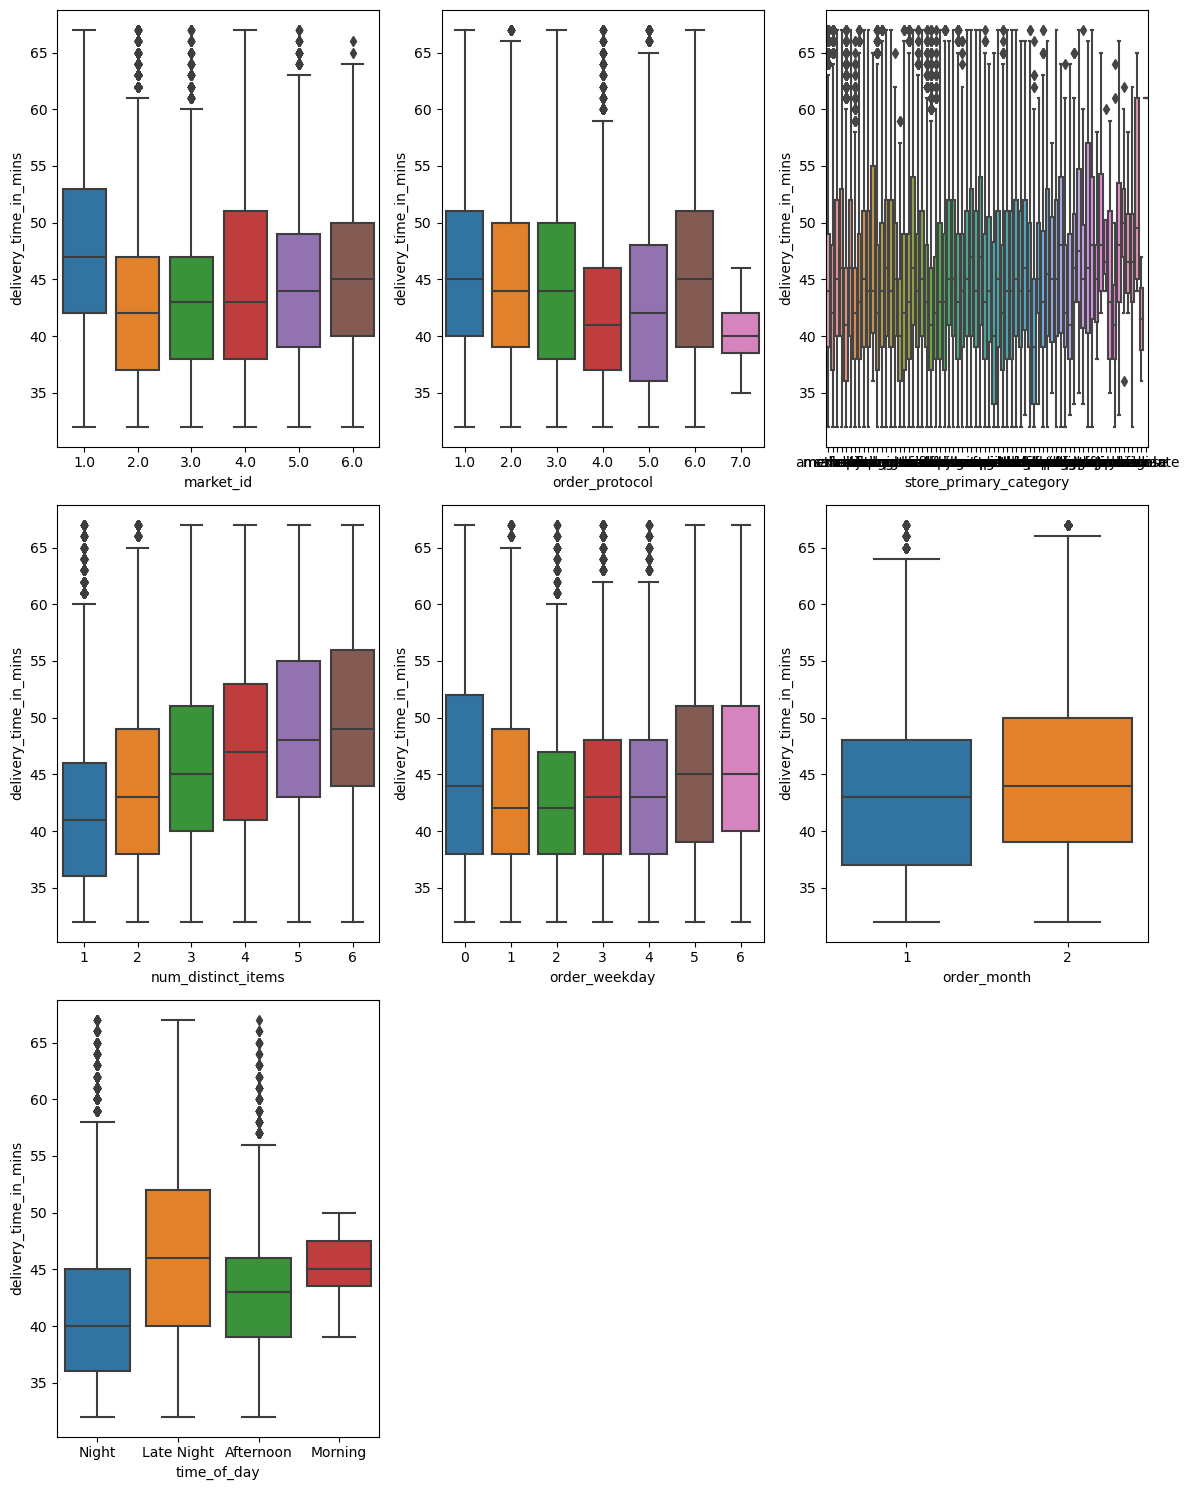

In [66]:
t=1
plt.figure(figsize= (12,15))
for i in cat_cols:
    plt.subplot(3,3,t)
    sns.boxplot(x= data[i], y= data['delivery_time_in_mins'])
    t+=1
plt.tight_layout()
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. Deliveries are delayed on Saturday,Sunday and monday as compared to other days. This is maybe due to high demand and low availability of delivery executives on weekends.
<br>
2. The orders from Market_id 1 and 4 were delayed as compared to the orders from market id 2,3,5 and 6.<br>
3. The orders that were received through third party apps took less time to deliver as compared to the orders that were placed through porter, or direct call to restaurant or pre-booked ones etc.<br>
4. Later in the night, the delivery is delayed due to large number of orders and less availability of partners whereas the delivery is fast during the non-peak hours i.e in the morning and afternoon due to less orders and more partners that are available to deliver them.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

**Top 10 Earning stores**

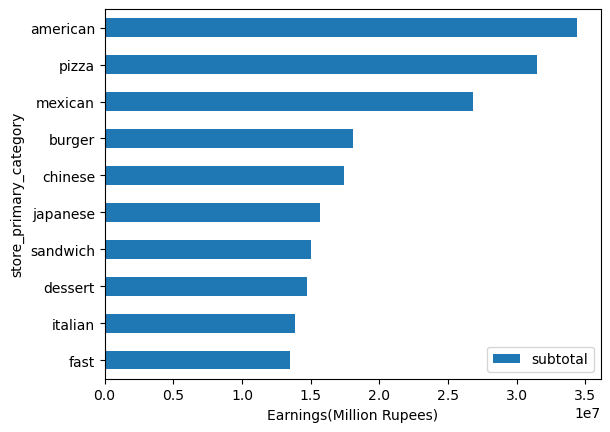

In [67]:
data.groupby('store_primary_category')['subtotal'].sum().to_frame().sort_values('subtotal', ascending=True)[-10:].plot(kind='barh')
plt.xlabel('Earnings(Million Rupees)')
plt.show()

**Total earning of markets**

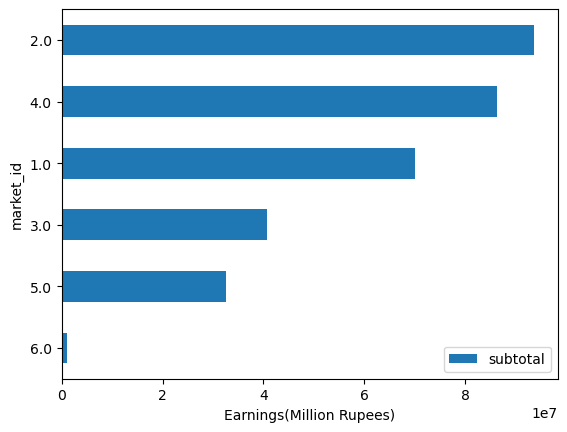

In [68]:
data.groupby('market_id')['subtotal'].sum().to_frame().sort_values('subtotal', ascending=True).plot(kind='barh')
plt.xlabel('Earnings(Million Rupees)')
plt.legend(loc='lower right')
plt.show()

**Let's check the Correlation between variables**

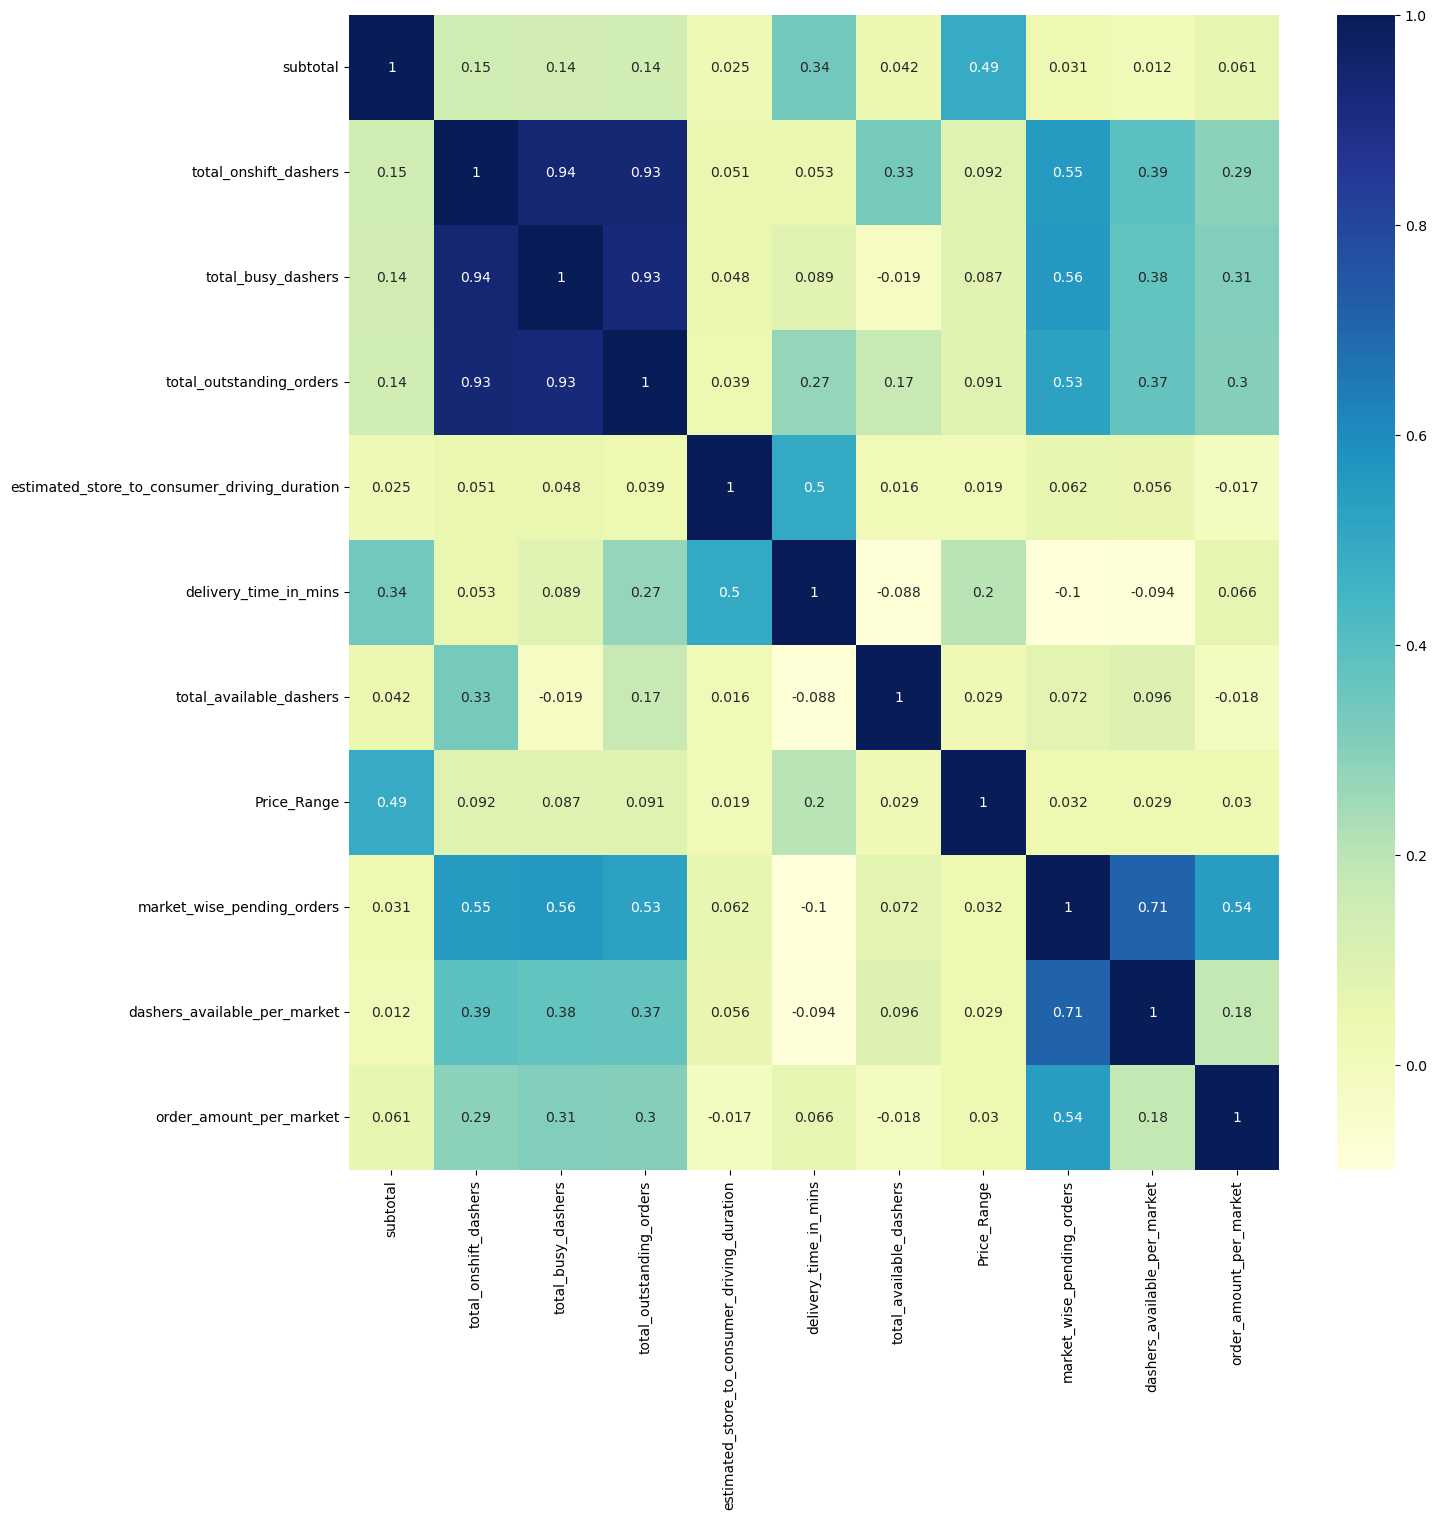

In [69]:
plt.figure(figsize= (15,15))
sns.heatmap(data[num_cols].corr(), annot= True, cmap='YlGnBu')
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. Onshift dashers, busy dashers and outstanding orders have very high correlation between them. This might lead to multicollinearity in ols models.<br>
2. Estimated time have highest correlation with the target followed by subtotal, outstanding orders, max price and price range.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='statistic'> </a> 
## 9. Statistical Analysis

In [70]:
# Ho: That the Predictor variables & target variable are independent of each other.
# This means one does not affect the other. In other words, the predictors 
# don't contribute in predicting the target variable.

# Ha: That the Predictors & target variable are dependent on each other.
# The predictor is a significant feature for the target.

for i in num_cols:
    if i!='delivery_time_in_mins':
        statistics, pvalue= stats.ttest_ind(data[i], data['delivery_time_in_mins'])
        if pvalue<0.05:
            print('Pvalue for',i,'is:',pvalue )
        else:
            print('Pvalue for',i,'is:',pvalue,'(Not Significant)')

Pvalue for subtotal is: 0.0
Pvalue for total_onshift_dashers is: 0.0
Pvalue for total_busy_dashers is: 0.0
Pvalue for total_outstanding_orders is: 0.0
Pvalue for estimated_store_to_consumer_driving_duration is: 0.0
Pvalue for total_available_dashers is: 0.0
Pvalue for Price_Range is: 0.0
Pvalue for market_wise_pending_orders is: 1.7037043660435944e-94
Pvalue for dashers_available_per_market is: 0.0
Pvalue for order_amount_per_market is: 0.0


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Since the pvalue of all the columns is less than 0.05, we reject the null hypothesis and conclude that all columns are significant variables and aid in predicting the target variable.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

In [71]:
cat_cols

['market_id',
 'order_protocol',
 'store_primary_category',
 'num_distinct_items',
 'order_weekday',
 'order_month',
 'time_of_day']

In [72]:
model= sms.ols('delivery_time_in_mins~time_of_day+store_primary_category + order_weekday + order_month + market_id + \
order_protocol + num_distinct_items', data).fit()

In [73]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
time_of_day,3.0,9.190222e+05,306340.725935,6082.462498,0.000000e+00
store_primary_category,71.0,1.572366e+05,2214.600427,43.971379,0.000000e+00
order_weekday,1.0,4.328683e+04,43286.826707,859.469466,2.308872e-188
order_month,1.0,7.779290e+04,77792.896364,1544.595069,0.000000e+00
market_id,1.0,5.685385e+04,56853.849123,1128.845680,1.639383e-246
order_protocol,1.0,2.044227e+05,204422.745355,4058.858575,0.000000e+00
num_distinct_items,1.0,3.696031e+05,369603.057914,7338.550015,0.000000e+00
Residual,142850.0,7.194582e+06,50.364589,NaN,NaN


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Since the pvalue of all categorical variables is less than 0.05, we reject the null hypothesis and conclude that all categorical variables are significant and aid in predicting the target variable.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>


<a id='encoding'> </a>
## 10. Encoding Categorical Variables

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Let's encode the categorical variables.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

###### Since there are 73 unique categories in `store_primary_category`, frequency encoding seems to be the good fit.

In [74]:
freq= data['store_primary_category'].value_counts(normalize= True).to_dict()

In [75]:
data['store_primary_category']= data['store_primary_category'].map(freq)

###### `time_of_day` is  nominal and has only 4 categories,  creating dummy variables would be the best fit.

In [76]:
data['time_of_day'].unique()

array(['Night', 'Late Night', 'Afternoon', 'Morning'], dtype=object)

In [77]:
data.dtypes

market_id                                       float64
store_primary_category                          float64
order_protocol                                  float64
subtotal                                          int64
num_distinct_items                                int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_store_to_consumer_driving_duration    float64
delivery_time_in_mins                           float64
order_month                                       int64
time_of_day                                      object
order_weekday                                     int64
total_available_dashers                         float64
Price_Range                                       int64
market_wise_pending_orders                      float64
dashers_available_per_market                    float64
order_amount_per_market                         

In [78]:
data= pd.get_dummies(data, drop_first= True)

In [79]:
data.head(5)

,market_id,store_primary_category,order_protocol,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time_in_mins,order_month,order_weekday,total_available_dashers,Price_Range,market_wise_pending_orders,dashers_available_per_market,order_amount_per_market,time_of_day_Late Night,time_of_day_Morning,time_of_day_Night
0,1.0,0.105275,1.0,3441,4,33.0,14.0,21.0,861.0,47.0,2,4,19.0,682,21.0,0.0,2027.0,0,0,1
1,2.0,0.092080,2.0,1900,1,1.0,2.0,2.0,690.0,44.0,2,1,-1.0,0,62.0,2.0,1990.0,0,0,1
2,2.0,0.035829,3.0,4771,3,8.0,6.0,18.0,289.0,55.0,2,0,2.0,784,62.0,2.0,1990.0,1,0,0
3,1.0,0.031876,1.0,1525,1,5.0,6.0,8.0,795.0,59.0,2,3,-1.0,0,21.0,0.0,2027.0,1,0,0
4,1.0,0.031876,1.0,4475,3,4.0,1.0,1.0,542.0,56.0,2,4,3.0,900,21.0,0.0,2027.0,1,0,0


<a id='scaling'> </a>
## 11.Scaling and Transformation

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Some numerical variables has large values as compared to the other variables, we need to bring these to the same scale as others,let's scale these variables.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

In [80]:
sc= StandardScaler()

for i in num_cols:
    data[i]= sc.fit_transform(pd.DataFrame(data[i]))

In [81]:
data.head()

,market_id,store_primary_category,order_protocol,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time_in_mins,order_month,order_weekday,total_available_dashers,Price_Range,market_wise_pending_orders,dashers_available_per_market,order_amount_per_market,time_of_day_Late Night,time_of_day_Morning,time_of_day_Night
0,1.0,0.105275,1.0,0.976862,4,-0.246148,-0.835661,-0.678270,1.485280,0.322592,2,4,1.556320,0.702807,-0.985742,-1.311179,0.232037,0,0,1
1,2.0,0.092080,2.0,-0.306744,1,-1.304847,-1.256327,-1.119241,0.692817,-0.054991,2,1,-0.341837,-0.998316,0.839954,0.256928,-0.351875,0,0,1
2,2.0,0.035829,3.0,2.084711,3,-1.073256,-1.116105,-0.747897,-1.165531,1.329479,2,0,-0.057113,0.957227,0.839954,0.256928,-0.351875,1,0,0
3,1.0,0.031876,1.0,-0.619108,1,-1.172509,-1.116105,-0.979987,1.179417,1.832923,2,3,-0.341837,-0.998316,-0.985742,-1.311179,0.232037,1,0,0
4,1.0,0.031876,1.0,1.838152,3,-1.205594,-1.291382,-1.142450,0.006943,1.455340,2,4,0.037794,1.246568,-0.985742,-1.311179,0.232037,1,0,0


<a id='split'> </a>
## 12. Train Test Split

In [82]:
X= data.drop(columns= 'delivery_time_in_mins', axis=1)
y= data['delivery_time_in_mins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.3)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (100051, 19)
y_train (100051,)
X_test (42879, 19)
y_test (42879,)


<a id='model'> </a>
## 13. Model Building

<table align="left">
    <tr>
        <td width="6%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Let's check the assumption of multicollinearity in the dataset which is done before building the model.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

In [83]:
vif= pd.DataFrame()
vif['vif_value']= [VIF(X_train.values,i) for i in range(0,X_train.shape[1])]
vif['columns']= X_train.columns
vif.sort_values('vif_value', ascending=False)

,vif_value,columns
5,inf,total_onshift_dashers
11,inf,total_available_dashers
6,inf,total_busy_dashers
0,18.878961,market_id
9,11.476487,order_month
7,9.913587,total_outstanding_orders
16,9.574000,time_of_day_Late Night
4,8.986436,num_distinct_items
14,8.610523,dashers_available_per_market
13,6.579212,market_wise_pending_orders


<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> Variables total onshift and total busy partners have high multicollinearity that is because of the very high correlation between them. Let's drop total available partners as it do not have good correlation with the target and is creating multicollinearity and check if the model improves.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

In [84]:
ols_data= data.copy()
ols_data.drop(columns=['total_available_dashers'], axis=1, inplace=True)

In [85]:
X= ols_data.drop(columns= 'delivery_time_in_mins', axis=1)
y= ols_data['delivery_time_in_mins']

ols_X_train, ols_X_test, ols_y_train, ols_y_test = train_test_split(X, y, random_state = 10, test_size = 0.3)

print('ols_X_train', ols_X_train.shape)
print('ols_y_train', ols_y_train.shape)
print('ols_X_test', ols_X_test.shape)
print('ols_y_test', ols_y_test.shape)

ols_X_train (100051, 18)
ols_y_train (100051,)
ols_X_test (42879, 18)
ols_y_test (42879,)


In [86]:
vif= pd.DataFrame()
vif['vif_value']= [VIF(ols_X_train.values,i) for i in range(0,ols_X_train.shape[1])]
vif['columns']= ols_X_train.columns
vif.sort_values('vif_value', ascending=False)

,vif_value,columns
0,18.878961,market_id
9,11.476487,order_month
5,11.429954,total_onshift_dashers
6,10.779403,total_busy_dashers
7,9.913587,total_outstanding_orders
15,9.574000,time_of_day_Late Night
4,8.986436,num_distinct_items
13,8.610523,dashers_available_per_market
12,6.579212,market_wise_pending_orders
17,4.926503,time_of_day_Night


### OLS Model

In [87]:
ols_X_train= sm.add_constant(ols_X_train)
ols_X_test= sm.add_constant(ols_X_test)

ols_model= sm.OLS(ols_y_train, ols_X_train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     delivery_time_in_mins   R-squared:                       0.894
Model:                               OLS   Adj. R-squared:                  0.894
Method:                    Least Squares   F-statistic:                 4.690e+04
Date:                   Mon, 17 Jul 2023   Prob (F-statistic):               0.00
Time:                           23:41:30   Log-Likelihood:                -29665.
No. Observations:                 100051   AIC:                         5.937e+04
Df Residuals:                     100032   BIC:                         5.955e+04
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.4141      0.009     46.941      0.000       0.397       0.431
market_id                                       -0.2019      0.002   -114.332      0.000      -0.205      -0.198
store_primary_category                          -0.2309      0.033     -7.070      0.000      -0.295      -0.167
order_protocol                                  -0.0820      0.001   -118.047      0.000      -0.083      -0.081
subtotal                                         0.2109      0.001    151.158      0.000       0.208       0.214
num_distinct_items                               0.0484      0.001     39.537      0.000       0.046       0.051
total_onshift_dashers                           -1.3682      0.003   -391.490      0.000      -1.375      -1.361
total_busy_dashers                              -0.4256      0.003   -125.765      0.000      -0.432      -0.419
total_outstanding_orders                         1.8981      0.003    586.468      0.000       1.892       1.904
estimated_store_to_consumer_driving_duration     0.5219      0.001    504.595      0.000       0.520       0.524
order_month                                      0.0125      0.002      5.559      0.000       0.008       0.017
order_weekday                                    0.0314      0.001     60.889      0.000       0.030       0.032
Price_Range                                      0.0064      0.001      4.874      0.000       0.004       0.009
market_wise_pending_orders                      -0.4342      0.003   -146.978      0.000      -0.440      -0.428
dashers_available_per_market                     0.3428      0.004     97.881      0.000       0.336       0.350
order_amount_per_market                          0.1892      0.001    134.252      0.000       0.186       0.192
time_of_day_Late Night                           0.3292      0.005     70.340      0.000       0.320       0.338
time_of_day_Morning                              0.2118      0.103      2.056      0.040       0.010       0.414
time_of_day_Night                               -0.1423      0.005    -31.245      0.000      -0.151      -0.133
==============================================================================
Omnibus:                    26470.772   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95479.029
Skew:                           1.304   Prob(JB):                         0.00
Kurtosis:                       7.012   Cond. No.                         621.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly s

<table align="left">
    <tr>
        <td width="6%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> 1. Model is significant as the pvalue of f-test is 0 which is less than alpha and it is 89.4 accurate in predicting the delivery time.<br>
                        2. Their is no autocorrelation among the variables as the durbing watson value is approx 2. <br>
                        3. The residuals i.e the error terms are pretty much normal as the pvalue of jarque bera is 0 which is less than alpha(0.05). <br>
                        4. Since the condition number greater than 100 but less than 1000, we can say that slight multicollinearity is still present.<br>
                        5. All the variables are statistically significant and aid in predicting the target variable.</b>                        
                </font>
            </div>
        </td>
    </tr>
</table>

In [88]:
y_pred= ols_model.predict(ols_X_test)
print('r2_score:', r2_score(ols_y_test, y_pred))
print('MSE:',mean_squared_error(ols_y_test, y_pred))
print('RMSE:',np.sqrt(mean_squared_error(ols_y_test, y_pred)))
print('MAE:',mean_absolute_error(ols_y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(ols_y_test, y_pred))

r2_score: 0.8942092352333959
MSE: 0.10578429427001632
RMSE: 0.3252449757798209
MAE: 0.23101393652348107
MAPE: 0.5965458921873387


**Let's find the top 5 significant features in the ols model**

In [89]:
# Independent variables (without the intercept term)
X_train_rfe = ols_X_train.iloc[:,1:]
X_test_rfe = ols_X_test.iloc[:,1:]

logreg = LinearRegression()

rfe_model = RFE(estimator = logreg, n_features_to_select = 5)
rfe_model = rfe_model.fit(X_train_rfe, ols_y_train)

feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe = feat_index[feat_index==1].index

print(signi_feat_rfe)

Index(['total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'time_of_day_Late Night'],
      dtype='object')


**Let's Build different models and find out which are performing best. We will use root mean squared error to cross validate the score on train dataset.**

In [90]:
# Dictionary of Models

def base_models():
    models = dict()
    models["lr"] = LinearRegression()
    models["tree"] = DecisionTreeRegressor()
    models["rf"] = RandomForestRegressor()
    models["ada"] = AdaBoostRegressor()
    models["gbm"] = GradientBoostingRegressor()
    models["xgb"] = XGBRegressor()
    return models

In [91]:
# Eval Metrics

def eval_scores(model):
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    score = np.abs(cross_val_score(model, X_train, y_train, 
                                   scoring = "neg_root_mean_squared_error", error_score="raise"))
    return score

In [92]:
# Lets Build the Models and Generate the Stats...
models = base_models() # Linking Base Models...

result, names = list(), list()

for name, model in models.items():
    finalscore = eval_scores(model)
    result.append(finalscore)
    names.append(name)
    print((name, np.mean(result)), np.std(result))

('lr', 0.32558234359004057) 0.0021465735231154842
('tree', 0.3706828985151031) 0.04514363422862638
('rf', 0.3308309575653026) 0.06735352462391608
('ada', 0.39487999571786686) 0.1253564210061365
('gbm', 0.3857419029582325) 0.11361019800024866
('xgb', 0.35163949759315744) 0.12873395580525152


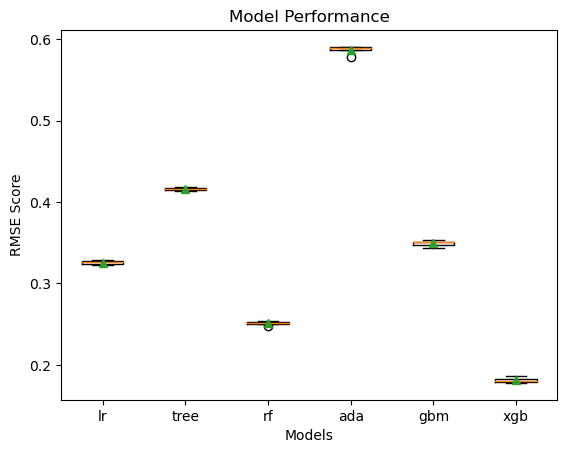

In [95]:
# Code for plotting this....

plt.boxplot(result, labels = names, showmeans = True)
plt.xlabel("Models")
plt.ylabel("RMSE Score")
plt.title("Model Performance")
plt.show()

Since random forest and xtreme gradient boosting models have the least error, we will build these models and evaluate how they are performing.

But first let's drop the available dashers which we dropped in ols model too due to multicollinearity, however random forest and xgboost do not have assumptions, but still it's better to drop to reduce bias.

In [659]:
X_train.drop(columns=['total_available_dashers'], axis=1, inplace=True)
X_test.drop(columns=['total_available_dashers'], axis=1, inplace=True)

### Random Forest

In [660]:
rf_reg= RandomForestRegressor(random_state = 10)
rf_model = rf_reg.fit(X_train, y_train)

y_pred_train= rf_model.predict(X_train)
y_pred_test= rf_model.predict(X_test)

In [661]:
print('r2_score:', r2_score(y_train, y_pred_train))
print('MSE:',mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('MAE:',mean_absolute_error(y_train, y_pred_train))
print('MAPE:',mean_absolute_percentage_error(y_train, y_pred_train))

r2_score: 0.9936478729239167
MSE: 0.006352292923431062
RMSE: 0.07970127303519726
MAE: 0.058742678829814814
MAPE: 0.17523793900997972


In [662]:
print('r2_score:', r2_score(y_test, y_pred_test))
print('MSE:',mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('MAE:',mean_absolute_error(y_test, y_pred_test))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_test))

r2_score: 0.955265657326188
MSE: 0.04473160658042749
RMSE: 0.2114984789080704
MAE: 0.1572667305386838
MAPE: 0.4606273738994201


We can clearly see that there is a huge difference between train and test accuracy, hence the model is highly over-fitted on the train data.

**Important Features of random forest**

<AxesSubplot:>

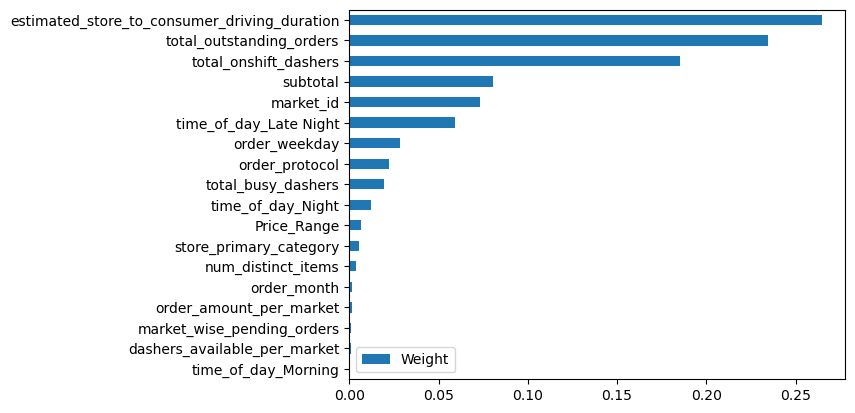

In [663]:
pd.DataFrame(rf_model.feature_importances_, index = rf_model.feature_names_in_, 
            columns =["Weight"]).sort_values(by = "Weight", ascending = True).\
plot(kind = "barh")

### XGBoost

In [664]:
xgb= XGBRegressor(random_state= 10)
xgb.fit(X_train, y_train)

y_pred_train= xgb.predict(X_train)
y_pred_test= xgb.predict(X_test)

In [665]:
print('XGBoost Train Evaluation:')
print('r2_score:', r2_score(y_train, y_pred_train))
print('MSE:',mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('MAE:',mean_absolute_error(y_train, y_pred_train))
print('MAPE:',mean_absolute_percentage_error(y_train, y_pred_train))

XGBoost Train Evaluation:
r2_score: 0.9761716056604638
MSE: 0.023829016473815898
RMSE: 0.15436650049092873
MAE: 0.11935040770903076
MAPE: 0.3660894119727166


In [666]:
print('XGBoost Test Evaluation:')
print('r2_score:', r2_score(y_test, y_pred_test))
print('MSE:',mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('MAE:',mean_absolute_error(y_test, y_pred_test))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_test))

XGBoost Test Evaluation:
r2_score: 0.9695933610939796
MSE: 0.030404779140154034
RMSE: 0.17436966232734993
MAE: 0.13396588019712782
MAPE: 0.4051808501055183


Since there is no significant difference between the train and test accuracy, the xgboost model is performing well on both train and test set.

**Important Features of XGB**

<AxesSubplot:>

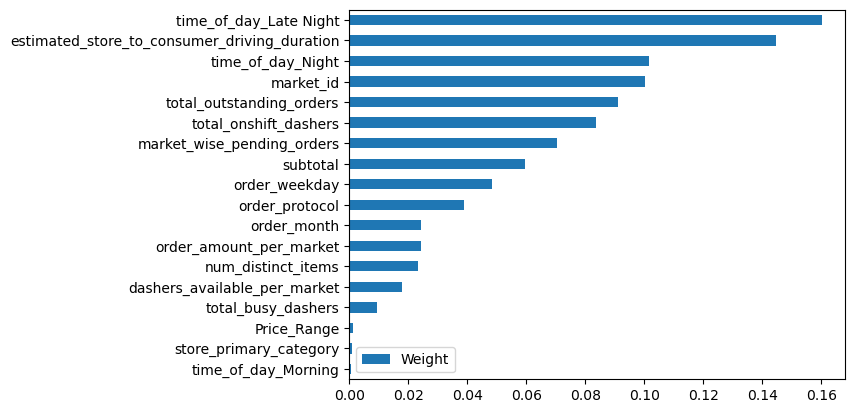

In [667]:
pd.DataFrame(xgb.feature_importances_, index = xgb.feature_names_in_, 
            columns =["Weight"]).sort_values(by = "Weight", ascending =True).\
plot(kind = "barh")

**Lets build XGB Model by using kfold cross validation approach**

In [668]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
xgb = XGBRegressor()
pred_xgb = []

for train_index, test_index in kfold.split(X_train,y_train):
    xtrain = X_train.iloc[train_index]
    ytrain = y_train.iloc[train_index]
    pred_xgb.append(xgb.fit(xtrain, ytrain).predict(X_test))
    
    
prediction = pd.DataFrame(pred_xgb).T.mean(axis = 1)

In [669]:
print('XGBoost Test Evaluation:')
print('r2_score:', r2_score(y_test, prediction))
print('MSE:',mean_squared_error(y_test, prediction))
print('RMSE:',np.sqrt(mean_squared_error(y_test, prediction)))
print('MAE:',mean_absolute_error(y_test, prediction))
print('MAPE:',mean_absolute_percentage_error(y_test, prediction))

XGBoost Test Evaluation:
r2_score: 0.9814806937152892
MSE: 0.018518173585572114
RMSE: 0.13608149611748144
MAE: 0.10395611738063226
MAPE: 0.3111087772409117


The model is performing well by kfold method and can be classified as the best fit model as it is 98.14% accurate in predicting the delivery time and the errors are also minimum.